In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
img = cv2.imread("3.jpeg", cv2.IMREAD_GRAYSCALE)

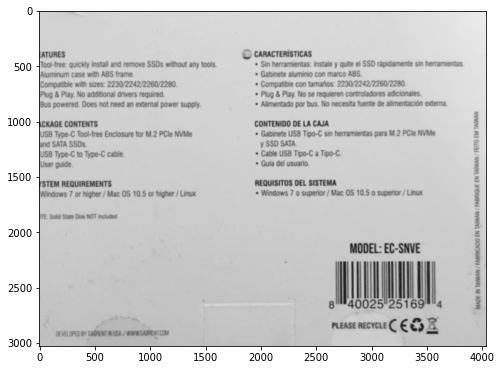

In [3]:
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray', interpolation='bicubic')

In [4]:
scale_percent = 30 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)

In [5]:
h = resized.shape[0] - resized.shape[0] % 10
w = resized.shape[1] - resized.shape[1] % 10
resized = resized[:h, :w]
h,w

(900, 1200)

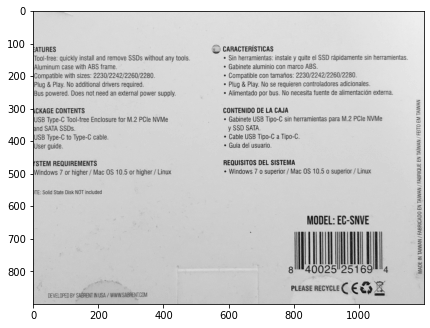

In [6]:
plt.figure(figsize=(7,7))
plt.imshow(resized, cmap="gray")

## STEP 1 : Divide the examined tile/photo into patches of here we choose 16x16 sized patches

In [7]:
img_patches = []

image = resized
ph, pw = 16, 16   ##WE CAN MODIFY THE PATCH DIMENSIONS HERE
for r in range(0, image.shape[0] - ph, ph):
    for c in range(0, image.shape[1] - pw, pw):
        patch = image[r:r+ph, c:c+pw]
        img_patches.append(patch)
img_patches = np.array(img_patches)

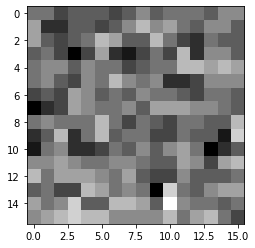

In [8]:
plt.imshow(img_patches[10], cmap='gray')

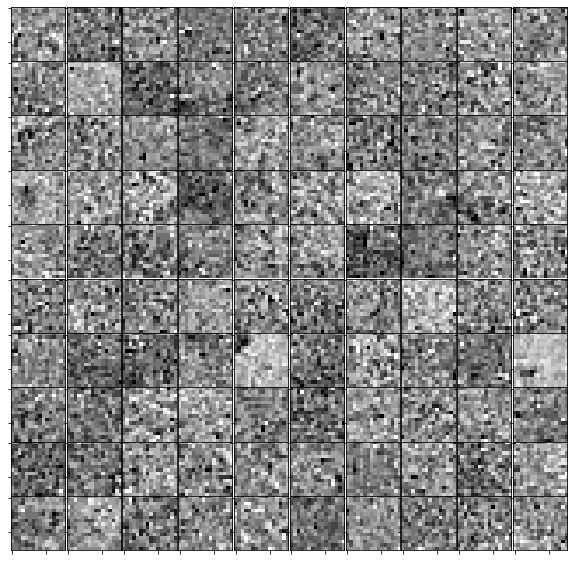

In [9]:
plt.figure(figsize = (10,10))
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0, hspace=0)
for i in range(10):
    for j in range(10):
        ax1 = plt.subplot(gs1[i, j])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        ax1.imshow(img_patches[150 + ph * i + j], cmap='gray')
plt.show()

## Step 2 : For each Pixel of a Patch generate a K-bits binary code (texton)

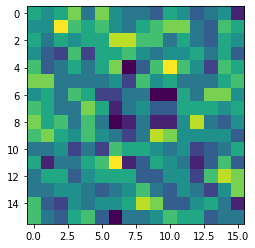

In [10]:
test_patch = img_patches[100]
plt.imshow(test_patch)

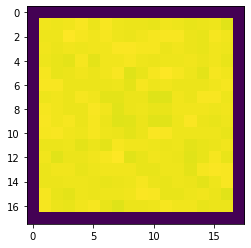

In [11]:
plt.imshow(np.pad(test_patch, ((1,1),(1,1)), 'constant'))

In [12]:
test_patch_pad = np.pad(test_patch, ((1,1),(1,1)), 'constant')
texton = []
def extract_elements(a):
    n = a.shape[0]
    r = np.minimum(np.arange(n)[::-1], np.arange(n))
    return a[np.minimum(r[:,None],r) < 1]

for i in range(ph):
    for j in range(pw):
        cell = test_patch_pad[i:i+3,j:j+3]
        cell_center = cell[1][1]
        compared_pixels = (extract_elements(cell) > cell_center).astype(int)
        texton.append(compared_pixels)
texton = np.array(texton)
texton.shape

(256, 8)

In [13]:
def extract_texton(patch):
    test_patch_pad = np.pad(patch, ((1,1),(1,1)), 'constant')
    texton = []
    def extract_elements(a):
        n = a.shape[0]
        r = np.minimum(np.arange(n)[::-1], np.arange(n))
        return a[np.minimum(r[:,None],r) < 1]

    for i in range(ph):
        for j in range(pw):
            cell = test_patch_pad[i:i+3,j:j+3]
            cell_center = cell[1][1]
            compared_pixels = (extract_elements(cell) > cell_center).astype(int)
            texton.append(compared_pixels)
    texton = np.array(texton)
    return texton
textons = np.array([extract_texton(i) for i in img_patches])

In [14]:
textons.shape

(4144, 256, 8)

## Step 3 : Calculate Histogram for each texton occuring in a patch, it should contain $2^8$ = 256 bins

In [15]:
def hist_from_texton(texton):
    #histogram = np.unique(texton, axis=0, return_counts=True)[1] 
    hist = np.zeros(256)
    for i in texton:
        val = int(''.join(list(map(str, i))), 2) # Converting Binary to Int '00000010'
        hist[val] += 1
    return hist
hist_test = hist_from_texton(texton)
sum(hist_test)

256.0

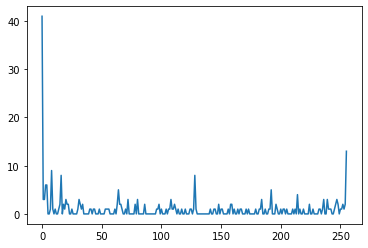

In [16]:
plt.plot(hist_test)

In [17]:
histograms = np.array([hist_from_texton(i) for i in textons])

In [18]:
histograms.shape #Patch Conctenation

(4144, 256)

## Some interactive tests to see if calculated data is correct

In [19]:
def h(i):
    plt.plot(histograms[i])

In [20]:
interact(h, i=widgets.IntSlider(min=0, max=histograms.shape[0] - 1, step=1, value=0), continuous_update=False);

interactive(children=(IntSlider(value=0, description='i', max=4143), Output()), _dom_classes=('widget-interact…

In [21]:
def f(x,y, s=3):
    plt.figure(figsize=(5,5))
    plt.imshow(test_patch_pad[y:y+s,x:x+s], cmap = "gray")

In [22]:
interact(f, x=widgets.IntSlider(min=0, max=ph - 1, step=1, value=0),
            y=widgets.IntSlider(min=0, max=pw - 1, step=1, value=0), s=fixed(3), continuous_update=True);

interactive(children=(IntSlider(value=0, description='x', max=15), IntSlider(value=0, description='y', max=15)…

## KMEANS CLUSTERING

### TODO
- ### Kmeans k=16,32 features

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [55]:
X_std = StandardScaler().fit_transform(histograms)

kmeans = KMeans(n_clusters=32, random_state=0).fit(X_std)

In [56]:
kmeans.labels_

array([16, 13, 19, ..., 16,  7,  8], dtype=int32)

In [57]:
img_patches.shape, X_std.shape, kmeans.labels_.shape

((4144, 16, 16), (4144, 256), (4144,))

- ### Random color for a given centroid

In [58]:
colors = kmeans.labels_

In [59]:
reconstructed_image = np.zeros(resized.shape)
ph, pw = 16, 16   ##WE CAN MODIFY THE PATCH DIMENSIONS HERE
color = 0
for r in range(0, reconstructed_image.shape[0] - ph, ph):
    for c in range(0, reconstructed_image.shape[1] - pw, pw):
        reconstructed_image[r:r+ph, c:c+pw] = np.ones(reconstructed_image[r:r+ph, c:c+pw].shape) * colors[color]
        color += 1

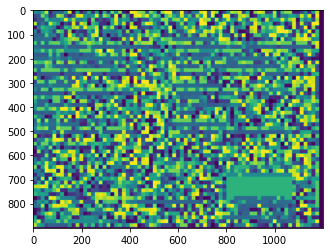

In [60]:
plt.imshow(reconstructed_image)

- ### Attribute a color to patches according to their nearest centroid

- ### Reconstruct image using the colors attributed to each patches